In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
from mgen import rotation_from_angles

import itertools

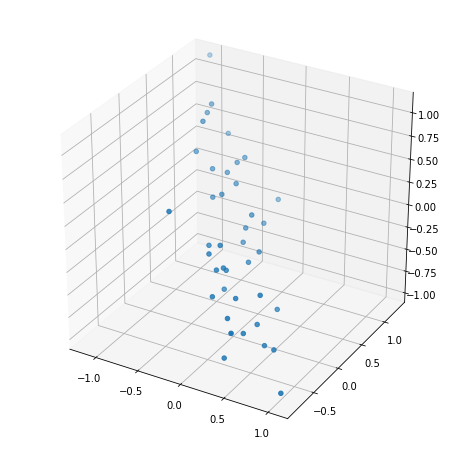

In [2]:
slope = 3
alpha = np.arctan(slope)
N = 40

# create the covariance matrix for the sampled Gaussian by taking a diagonal matrix
# with the 3 eigenvalues, and rotating it using a rotation matrix with
# angles 
eigenvalues = [0.1, 0.3, 1]
rotmat = lambda a: np.array([[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]])
C = np.diag(eigenvalues) @ rotation_from_angles([np.pi/4, np.pi/4, 0], 'XYZ')
d = C.shape[0]
X = np.random.randn(N,d) @ C

# center X around the origin (without loss of generality, it makes things easier later on)
X = X - np.repeat(X.mean(0, keepdims=True), X.shape[0], axis=0)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:, 2], '.')
ax.axis('equal');

In [3]:
# calculate the covariance matrix (no need to subtract the mean since we already know it is 0)
C = (X.T @ X)/N
print('Covariance matrix: C = \n', C.round(3))
print('trace(C) = %.3g' % C.trace())
U, S, _ = svd(C)

print('\nEigenvalues of C (decreasing order): ', S.round(3))
print('sum(S) = %.3g' % sum(S))

# rotate the data so that the covariance matrix is diagonal
X_U = X @ U

Covariance matrix: C = 
 [[ 0.307 -0.337 -0.302]
 [-0.337  0.58   0.342]
 [-0.302  0.342  0.318]]
trace(C) = 1.21

Eigenvalues of C (decreasing order):  [1.077 0.117 0.011]
sum(S) = 1.21


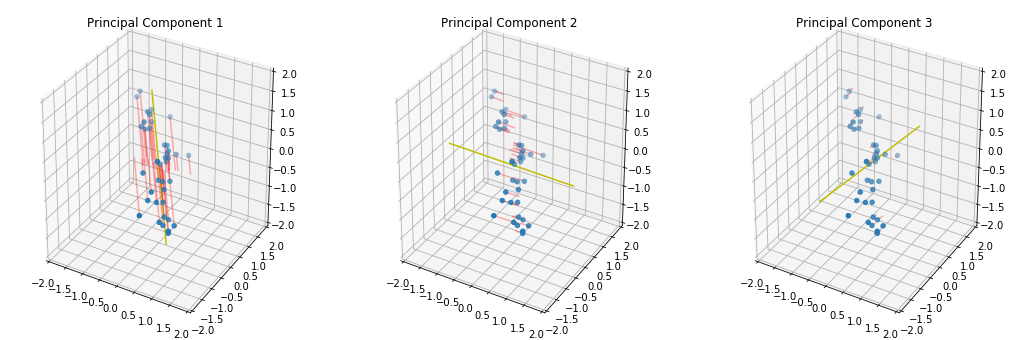

In [9]:
fig = plt.figure(figsize=(18, 6))

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:, 2], '.')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_title('Principal Component %d' % (i+1))

    # draw the TLS regression line (i.e. the line defined by this PC)
    PC_line = np.vstack([-2 * U[:, i], 2 * U[:, i]])
    ax.plot(PC_line[:, 0], PC_line[:, 1], PC_line[:, 2], 'y-')

    # draw the PC1 residuals (i.e. projections to the hyperplane perpendicular to PC1 that goes through the origin)
    other_PCs = list(set(range(3)).difference([i]))
    P1 = U[:, other_PCs] @ U[:, other_PCs].T # projection matrix that removes PC1
    for k in range(X_U.shape[0]):
        res = np.vstack([X[k, :], P1 @ X[k, :]])
        ax.plot(res[:, 0], res[:, 1], res[:, 2], 'r-', alpha=0.3)


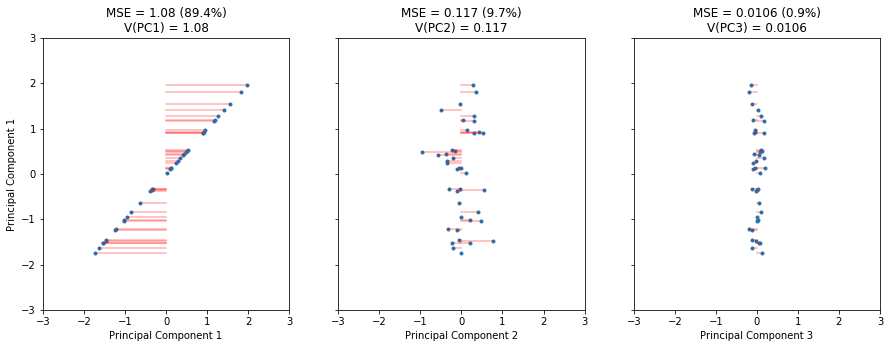

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
axs[0].set_ylabel('Principal Component %d' % (i+1))

for ax, (i, j) in zip(axs.flat, [[0, 0], [0, 1], [0, 2]]):
    ax.plot(X_U[:, j], X_U[:, i], '.', alpha=1)
    for k in range(X_U.shape[0]):
        ax.plot([X_U[k, j], 0], [X_U[k, i], X_U[k, i]], 'r-', alpha=0.3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel('Principal Component %d' % (j+1))
    
    mse = np.mean(X_U[:, j]**2)
    ax.set_title('MSE = %.3g (%.1f%%)\nV(PC%d) = %.3g' % (mse, 100.0*mse/sum(S), j+1, S[j]))